In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
tf.__version__

'2.8.0'

# 1. 資料準備

In [3]:
from tensorflow.keras.datasets import cifar10

In [4]:
(x_train_image,y_train_label),\
(x_test_image,y_test_label)= cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [5]:
y_train_label=y_train_label.reshape(-1)
y_test_label=y_test_label.reshape(-1)

In [6]:
x_train_normalize = x_train_image.astype('float32') / 255.0
x_test_normalize = x_test_image.astype('float32') / 255.0

In [7]:
from tensorflow.keras import utils
y_train_onehot = utils.to_categorical(y_train_label)
y_test_onehot = utils.to_categorical(y_test_label)

In [8]:
print("train data:",'images:',x_train_normalize.shape," labels:",y_train_onehot.shape) 
print("test  data:",'images:',x_test_normalize.shape ," labels:",y_test_onehot.shape) 

train data: images: (50000, 32, 32, 3)  labels: (50000, 10)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 10)


In [9]:
class_names =["airplane","automobile","bird","cat","deer",
       "dog","frog","horse","ship","truck"]

# 建立模型

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,MaxPooling2D
from tensorflow.keras.layers import Flatten,Conv2D,Softmax
from tensorflow.keras import Input,Model

In [11]:
class CNN_Model(tf.keras.Model):
  def __init__(self):
    super(CNN_Model, self).__init__(name='CNN_Model')
    self.conv1 = Conv2D(
        filters=32, kernel_size=(5,5),
        padding='same',activation='relu')
    self.max_pool1 = MaxPooling2D(pool_size=(2, 2))
    self.conv2 = Conv2D(
        filters=64, kernel_size=(5,5),
        padding='same',activation='relu')
    self.max_pool2 = MaxPooling2D(pool_size=(2, 2))
    self.flatten = Flatten()
    self.fc1 = Dense(750, activation='relu')
    self.dropout = Dropout(0.5)
    self.out_layer = Dense(10)
    self.softmax = Softmax()
  def call(self, x):
    x = self.conv1(x)  
    x = self.max_pool1(x)
    x = self.conv2(x)      
    x = self.max_pool2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.out_layer(x)
    x = self.softmax(x)
    return x


In [12]:
model = CNN_Model()

In [13]:
model.build(input_shape=(None, 32,32,3))

In [14]:
print(model.summary())

Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  2432      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  51264     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  30

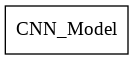

In [15]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [17]:
train_history=model.fit(
    x=x_train_normalize,y=y_train_onehot,
    validation_split=0.2,batch_size=200,epochs=10,verbose=2)       

Epoch 1/10
200/200 - 106s - loss: 1.6466 - acc: 0.4006 - val_loss: 1.3705 - val_acc: 0.5050 - 106s/epoch - 531ms/step
Epoch 2/10
200/200 - 102s - loss: 1.2661 - acc: 0.5473 - val_loss: 1.1346 - val_acc: 0.6006 - 102s/epoch - 509ms/step
Epoch 3/10
200/200 - 100s - loss: 1.0857 - acc: 0.6127 - val_loss: 1.0531 - val_acc: 0.6306 - 100s/epoch - 498ms/step
Epoch 4/10
200/200 - 100s - loss: 0.9615 - acc: 0.6593 - val_loss: 0.9662 - val_acc: 0.6591 - 100s/epoch - 500ms/step
Epoch 5/10


In [18]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train_key,valid_key):
    plt.plot(train_history.history[train_key],'--')
    plt.plot(train_history.history[valid_key])
    plt.title('Train History')
    plt.ylabel(train_key)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

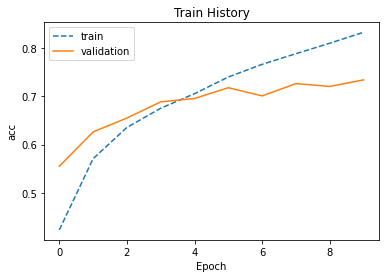

In [19]:
show_train_history(train_history,'acc','val_acc')

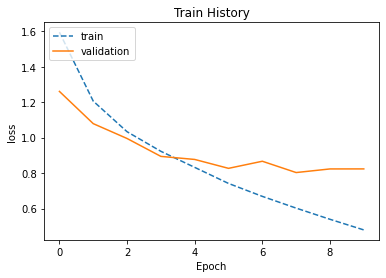

In [20]:
show_train_history(train_history,'loss','val_loss')

# 評估模型準確率

In [21]:
scores = model.evaluate(x_test_normalize, y_test_onehot,verbose=2)

313/313 - 1s - loss: 0.8425 - acc: 0.7274 - 1s/epoch - 4ms/step


In [22]:
print('test_loss=',scores[0],'test_acc=',scores[1])

test_loss= 0.8425340056419373 test_acc= 0.727400004863739


# 進行預測

In [23]:
probability = model.predict(x_test_normalize)

In [24]:
prediction=tf.argmax(probability, axis=-1).numpy() 

In [25]:
prediction

array([3, 8, 8, ..., 5, 1, 7])

# 查看預測結果

In [26]:
import matplotlib.pyplot as plt 

In [27]:
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
      5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [28]:
def plot_images_labels_prediction(
    images,labels,prediction,idx,num=10):
    fig = plt.gcf().set_size_inches(12, 12)    
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')
        title= str(idx)+',' +label_dict[labels[idx]]
        if len(prediction)>0:
            title+="=>"+label_dict[prediction[idx]]
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

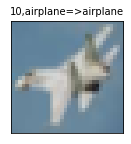

In [29]:
plot_images_labels_prediction(x_test_image,y_test_label,prediction,idx=10,num=1)

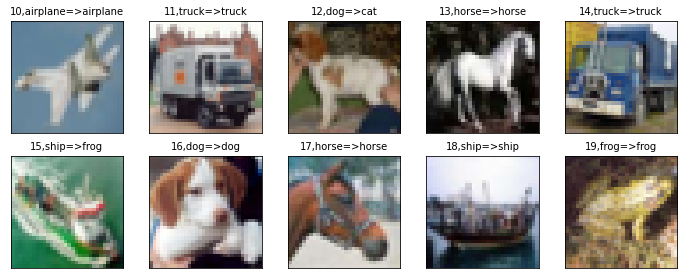

In [30]:
plot_images_labels_prediction(x_test_image,y_test_label,prediction,idx=10,num=10)

# 查看預測機率

In [31]:
def show_predicted_probability(
    images,labels,prediction,probability,idx):
  plt.figure(figsize=(1,1));
  plt.xticks([]);plt.yticks([])
  plt.imshow(images[idx],cmap='binary') 
  plt.show()
  if len(labels)>0:print('label:',label_dict[labels[idx]])
  if len(prediction)>0:print('predict:',label_dict[prediction[idx]])
  for i in range(10):
    print('%-10s Probability:%.9f'%(label_dict[i],probability[idx][i]))     

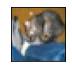

label: cat
predict: cat
airplane   Probability:0.005555158
automobile Probability:0.001388853
bird       Probability:0.000080120
cat        Probability:0.941619575
deer       Probability:0.000040688
dog        Probability:0.034243755
frog       Probability:0.000231310
horse      Probability:0.000114210
ship       Probability:0.015552065
truck      Probability:0.001174248


In [32]:
show_predicted_probability(x_test_image,y_test_label,prediction,probability,0) 

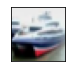

label: ship
predict: ship
airplane   Probability:0.007519765
automobile Probability:0.040060654
bird       Probability:0.000000009
cat        Probability:0.000000126
deer       Probability:0.000000001
dog        Probability:0.000000001
frog       Probability:0.000000005
horse      Probability:0.000000000
ship       Probability:0.952234745
truck      Probability:0.000184703


In [33]:
show_predicted_probability(x_test_image,y_test_label,prediction,probability,1) 

# confusion matrix

In [34]:
import pandas as pd

In [35]:
cm=pd.crosstab(index=y_test_label,columns=prediction,
       rownames=['label'],colnames=['predict'])

In [36]:
cm

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,825,10,25,17,20,3,6,15,46,33
1,20,834,8,11,2,2,2,3,24,94
2,69,7,545,85,101,49,52,65,17,10
3,24,15,30,595,78,121,38,62,12,25
4,27,2,43,63,712,12,24,104,10,3
5,19,8,34,207,51,555,13,89,18,6
6,14,13,34,76,62,23,747,15,8,8
7,15,3,12,30,40,38,2,849,2,9
8,89,36,8,14,5,5,2,8,814,19


#heapmap cm

In [37]:
import numpy as np

In [38]:
cm_mat=cm.to_numpy()

In [39]:
cm_mat

array([[825,  10,  25,  17,  20,   3,   6,  15,  46,  33],
       [ 20, 834,   8,  11,   2,   2,   2,   3,  24,  94],
       [ 69,   7, 545,  85, 101,  49,  52,  65,  17,  10],
       [ 24,  15,  30, 595,  78, 121,  38,  62,  12,  25],
       [ 27,   2,  43,  63, 712,  12,  24, 104,  10,   3],
       [ 19,   8,  34, 207,  51, 555,  13,  89,  18,   6],
       [ 14,  13,  34,  76,  62,  23, 747,  15,   8,   8],
       [ 15,   3,  12,  30,  40,  38,   2, 849,   2,   9],
       [ 89,  36,   8,  14,   5,   5,   2,   8, 814,  19],
       [ 40,  77,   5,  20,   1,   6,   5,  23,  25, 798]])

In [40]:
cm_mat.sum(axis=0)

array([1142, 1005,  744, 1118, 1072,  814,  891, 1233,  976, 1005])

In [41]:
cm_mat.sum(axis=1)[:, np.newaxis]

array([[1000],
       [1000],
       [1000],
       [1000],
       [1000],
       [1000],
       [1000],
       [1000],
       [1000],
       [1000]])

In [42]:
cm_norm = np.around(
    cm_mat.astype('float') / 
    cm_mat.sum(axis=1)[:, np.newaxis], 
    decimals=3)

In [43]:
cm_norm

array([[0.825, 0.01 , 0.025, 0.017, 0.02 , 0.003, 0.006, 0.015, 0.046,
        0.033],
       [0.02 , 0.834, 0.008, 0.011, 0.002, 0.002, 0.002, 0.003, 0.024,
        0.094],
       [0.069, 0.007, 0.545, 0.085, 0.101, 0.049, 0.052, 0.065, 0.017,
        0.01 ],
       [0.024, 0.015, 0.03 , 0.595, 0.078, 0.121, 0.038, 0.062, 0.012,
        0.025],
       [0.027, 0.002, 0.043, 0.063, 0.712, 0.012, 0.024, 0.104, 0.01 ,
        0.003],
       [0.019, 0.008, 0.034, 0.207, 0.051, 0.555, 0.013, 0.089, 0.018,
        0.006],
       [0.014, 0.013, 0.034, 0.076, 0.062, 0.023, 0.747, 0.015, 0.008,
        0.008],
       [0.015, 0.003, 0.012, 0.03 , 0.04 , 0.038, 0.002, 0.849, 0.002,
        0.009],
       [0.089, 0.036, 0.008, 0.014, 0.005, 0.005, 0.002, 0.008, 0.814,
        0.019],
       [0.04 , 0.077, 0.005, 0.02 , 0.001, 0.006, 0.005, 0.023, 0.025,
        0.798]])

In [44]:
class_names =["airplane","automobile","bird","cat","deer",
        "dog","frog","horse","ship","truck"]
cm_df = pd.DataFrame(cm_norm,index = class_names,columns = class_names)

In [45]:
cm_df

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,0.825,0.010,0.025,0.017,0.020,0.003,0.006,0.015,0.046,0.033
automobile,0.020,0.834,0.008,0.011,0.002,0.002,0.002,0.003,0.024,0.094
bird,0.069,0.007,0.545,0.085,0.101,0.049,0.052,0.065,0.017,0.010
cat,0.024,0.015,0.030,0.595,0.078,0.121,0.038,0.062,0.012,0.025
deer,0.027,0.002,0.043,0.063,0.712,0.012,0.024,0.104,0.010,0.003
dog,0.019,0.008,0.034,0.207,0.051,0.555,0.013,0.089,0.018,0.006
frog,0.014,0.013,0.034,0.076,0.062,0.023,0.747,0.015,0.008,0.008
horse,0.015,0.003,0.012,0.030,0.040,0.038,0.002,0.849,0.002,0.009
ship,0.089,0.036,0.008,0.014,0.005,0.005,0.002,0.008,0.814,0.019
truck,0.040,0.077,0.005,0.020,0.001,0.006,0.005,0.023,0.025,0.798


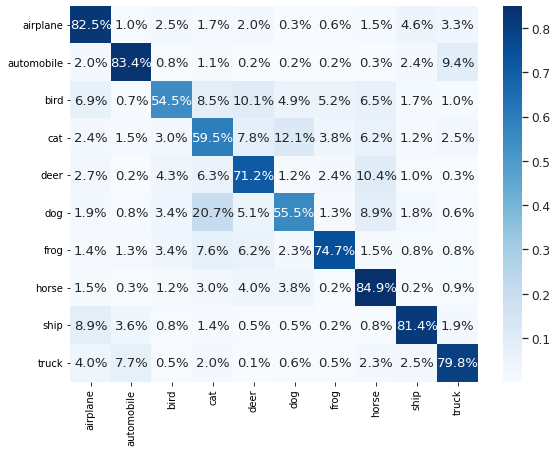

In [46]:
import seaborn as sns
figure = plt.figure(figsize=(8, 6))
plt.ylabel('Label')
plt.xlabel('Predicted')
plt.tight_layout()
sns.set(font_scale=1.1)
sns.heatmap(cm_df, annot=True,cmap=plt.cm.Blues,fmt='.1%')
plt.show()

#CF function

In [47]:
class_names =["airplane","automobile","bird","cat","deer",
              "dog","frog","horse","ship","truck"]
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
def plot_heatmap_confusion_matrix(cm_np):
  cm_norm = np.around(
      cm_np.astype('float') / 
      cm_np.sum(axis=1)[:, np.newaxis],decimals=3)
  cm_df = pd.DataFrame(cm_norm,index = class_names,columns = class_names)
  figure = plt.figure(figsize=(8, 6))
  plt.tight_layout();sns.set(font_scale=1)
  plt.ylabel('Label');plt.xlabel('Predicted')
  sns.heatmap(cm_df, annot=True,cmap=plt.cm.Blues,fmt='.1%')
  return figure

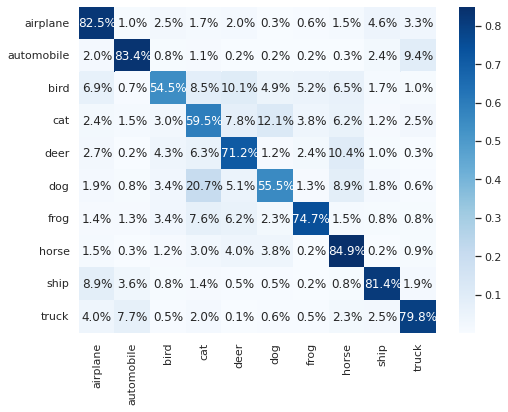

In [48]:
figure = plot_heatmap_confusion_matrix(cm.to_numpy())

In [49]:
df = pd.DataFrame({'label':y_test_label,'predict':prediction})

In [50]:
df[:5]

,label,predict
0,3,3
1,8,8
2,8,8
3,0,0
4,6,6


In [51]:
df[(df.label==5)&(df.predict==3)]

,label,predict
12,5,3
33,5,3
128,5,3
158,5,3
178,5,3
...,...,...
9823,5,3
9918,5,3
9928,5,3
9939,5,3


# 查看預測錯誤資料

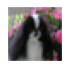

label: dog
predict: horse
airplane   Probability:0.000999105
automobile Probability:0.000007492
bird       Probability:0.000619476
cat        Probability:0.264070511
deer       Probability:0.000377631
dog        Probability:0.062580176
frog       Probability:0.000001690
horse      Probability:0.667768121
ship       Probability:0.002501961
truck      Probability:0.001073831


In [52]:
show_predicted_probability(x_test_image,y_test_label,prediction,probability,42)

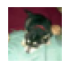

label: dog
predict: cat
airplane   Probability:0.000211108
automobile Probability:0.000203792
bird       Probability:0.005835939
cat        Probability:0.822272420
deer       Probability:0.000211168
dog        Probability:0.041270826
frog       Probability:0.129888043
horse      Probability:0.000101745
ship       Probability:0.000002242
truck      Probability:0.000002648


In [53]:
show_predicted_probability(x_test_image,y_test_label,prediction,probability,128)